In [1]:
from pandas.plotting import scatter_matrix
from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import pandas as pd
import numpy as np
import tarfile
import urllib.request
import matplotlib.pyplot as plt

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

housing.info()
print()
print(housing[:1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       

In [3]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


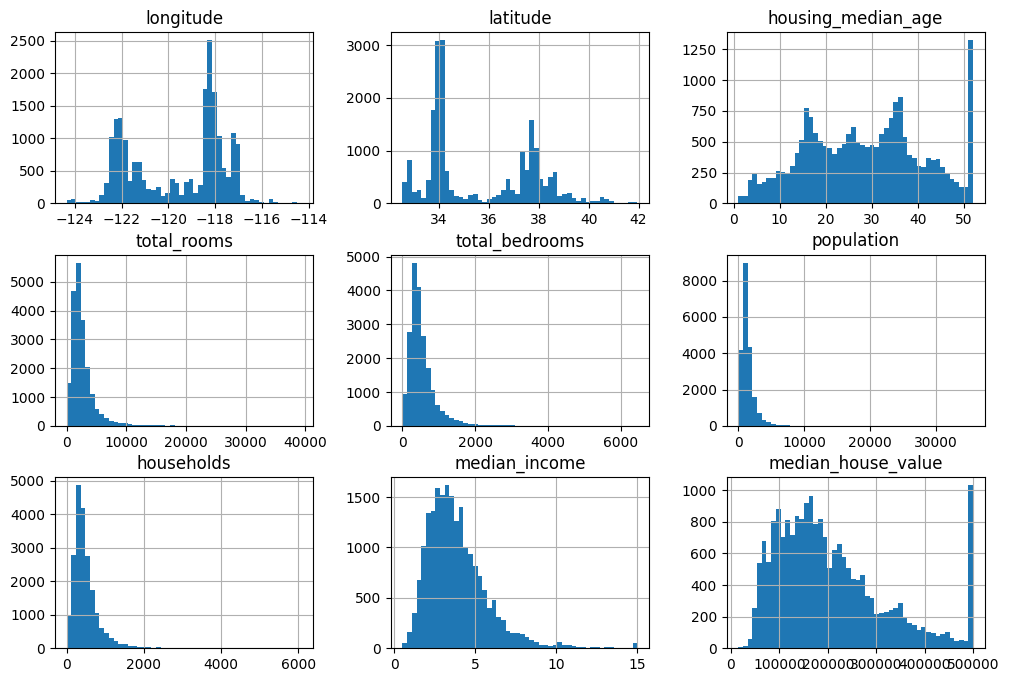

In [5]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

In the above charts, notice some things about the data:

* The `median_income` column is measured in \$10,000 units and is capped at 15.0001.
* The `housing_median_age` column is capped at 52.
* The `median_house_value` column is capped at \$500,001.

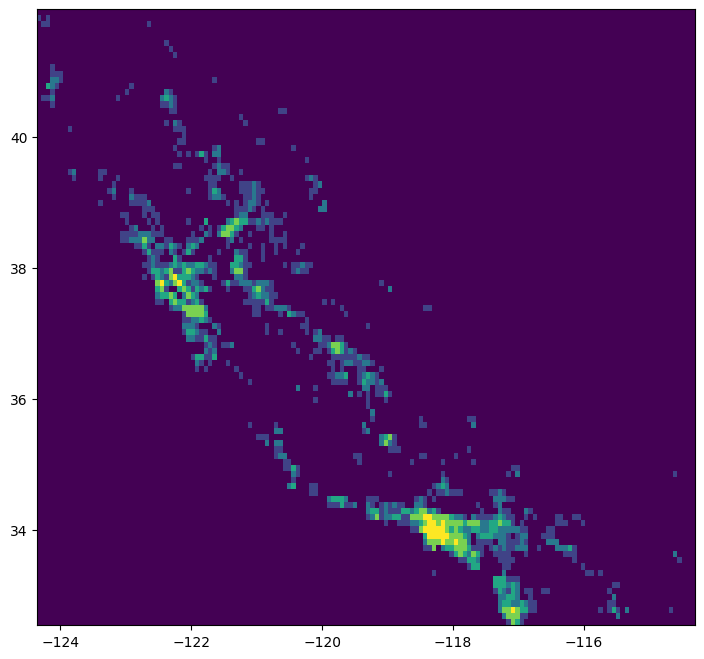

In [6]:
lat_min = housing["latitude"].min()
lat_max = housing["latitude"].max()
lat_bins = 100
lon_min = housing["longitude"].min()
lon_max = housing["longitude"].max()
lon_bins = 150

housing_llbins = housing.copy()
housing_llbins["latbin"] = np.minimum(
    np.int64((lat_max - housing_llbins["latitude"]) / (lat_max - lat_min) * lat_bins),
    lat_bins - 1,
)
housing_llbins["lonbin"] = np.minimum(
    np.int64((lon_max - housing_llbins["longitude"]) / (lon_max - lon_min) * lon_bins),
    lon_bins - 1,
)

bins = np.zeros((lat_bins, lon_bins))
for (lat, lon), count in housing_llbins[["latbin", "lonbin"]].value_counts().items():
    bins[lat][lon_bins - lon - 1] = np.int64(np.log(count + 1))

fig = plt.figure(figsize=(12, 8))
plt.imshow(bins, extent=[lon_min, lon_max, lat_min, lat_max])
plt.show()

del lat_min, lat_max, lon_min, lon_max, housing_llbins, bins

In [7]:
# This is a naive way to split up the train and test sets. If a dataset is expanded and is used for
# training the same model later, it's important that the old test set is not intermingled with the
# new train set. As you develop a model, you learn which kind of hyperparameter tunings are necessary
# and if you eventually see the entire set of data, you're effectively training on the entire dataset
# conceptually. This is fine for this simple example.

# This selection process also doesn't strive to preserve observed occurances in the real world.
# E.g. when sampling sets of people that follow the general population distribution, 51.1% should
# be female and 48.9% should be male.

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"{len(train_set)=}")
print(f"{len(test_set)=}")

len(train_set)=16512
len(test_set)=4128


In [8]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)

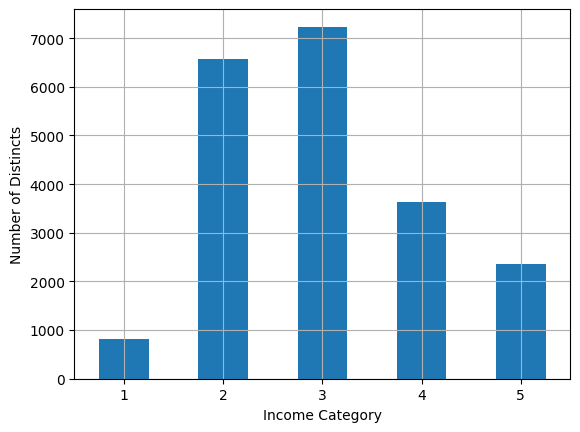

In [9]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Distincts")
plt.show()

<Axes: xlabel='income_cat'>

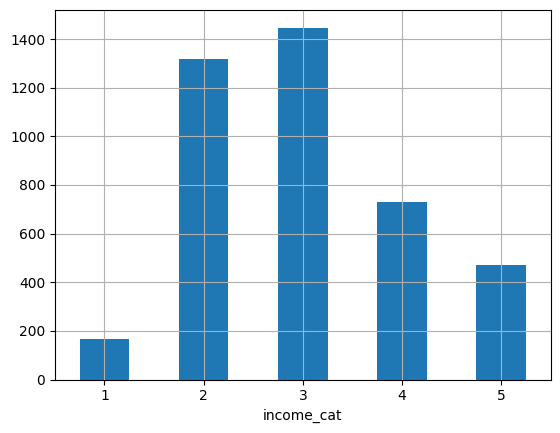

In [10]:
# It's possible to stratify our train/test sets so that we choose proportionally representative
# samples from our dataset. This is a manual approach.

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append((strat_train_set_n, strat_test_set_n))
strat_train_set, strat_test_set = strat_splits[0]

# Alternatively, the train_test_split() function can do this too.
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Visually we can see that the test set matches the entire dataset's distribution for this field.
strat_test_set["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [11]:
# We don't need the category in the end, we just wanted to use it for stratification.
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [12]:
housing = strat_train_set.copy()

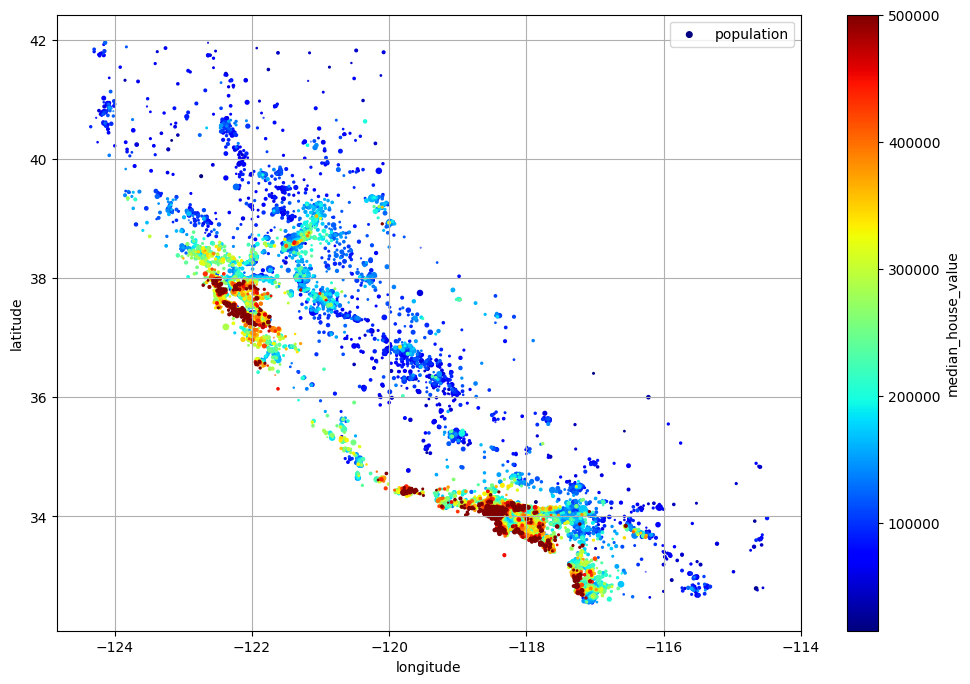

In [13]:
housing.sort_values(by="median_house_value").plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s=housing["population"] / 500, label="population",
    c="median_house_value", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(12, 8),
)
plt.show()

In [14]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

In [15]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

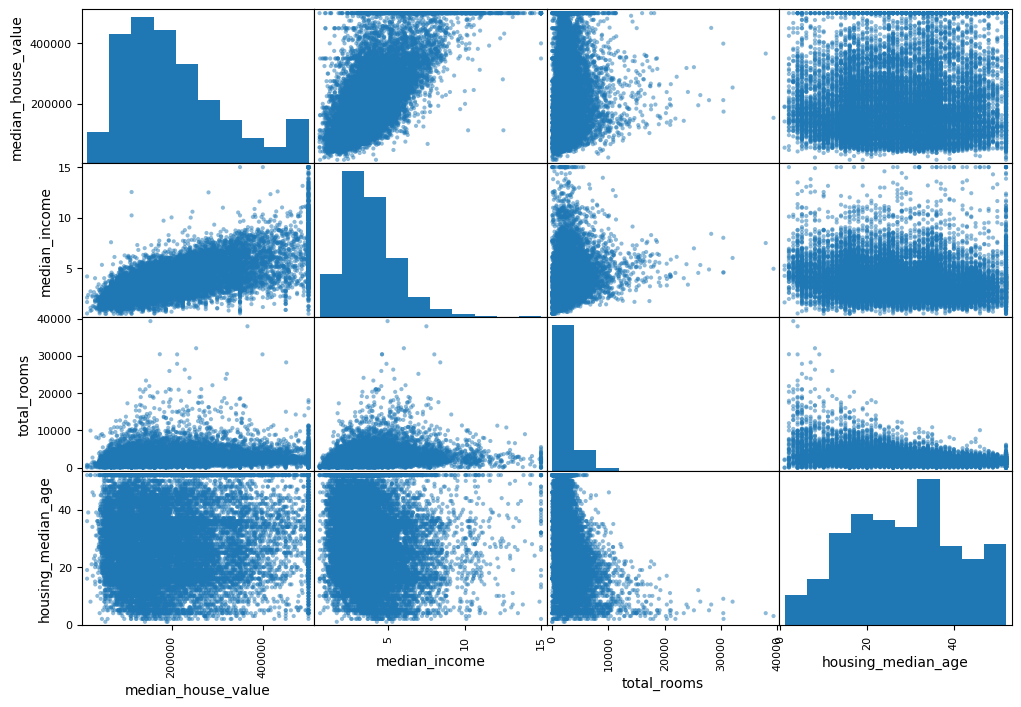

In [16]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

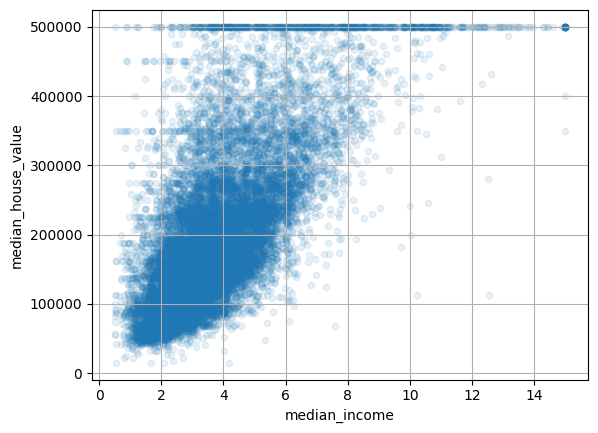

In [17]:
# Notice horizontal lines in the data at 450,000, 350,000, and 280,000.
# If these are left in the data set, the model could learn to reproduce these artifacts.
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [18]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [19]:
corr_matrix = housing.drop("ocean_proximity", axis=1).corr()

In [20]:
# We can see how some derived columns correlate with median_house_value.
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [22]:
# An imputer can be used to fill in any missing data points based on some strategy provided (median, mean, etc).
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

# Notice the calculated statistics are just the median values.
print(imputer.statistics_)
print(housing_num.median().values)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]
[-118.51     34.26     29.     2125.      434.     1167.      408.
    3.5385]


In [23]:
# We have a text field in our data. We can encode it to a number so machine learning algorithms can work with it easier.
housing_cat = housing[["ocean_proximity"]]
print(housing_cat.head(8))

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
print()
print("Categories:", ordinal_encoder.categories_)
print()
print(housing_cat_encoded[:8])

      ocean_proximity
13096        NEAR BAY
14973       <1H OCEAN
3785           INLAND
14689          INLAND
20507      NEAR OCEAN
1286           INLAND
18078       <1H OCEAN
4396         NEAR BAY

Categories: [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]

[[3.]
 [0.]
 [1.]
 [1.]
 [4.]
 [1.]
 [0.]
 [3.]]


In [24]:
# Alternatively, we can break out each category into its own column
# in the data which indicates the category with a 0 or 1 in the appropriate
# column.
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [25]:
# To turn a sparse matrix to a filled array, use the .toarrao() method.
print(housing_cat_1hot.toarray())
print()
print(cat_encoder.categories_)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [26]:
# Alternatively get_dummies can be used for a similar effect.
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test)

,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,True,False
1,False,True


In [27]:
# Or on the real data...
pd.get_dummies(housing_cat)

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,False,False,False,True,False
14973,True,False,False,False,False
3785,False,True,False,False,False
14689,False,True,False,False,False
20507,False,False,False,False,True
...,...,...,...,...,...
14207,True,False,False,False,False
13105,False,True,False,False,False
19301,False,False,False,False,True
19121,True,False,False,False,False


In [28]:
# When you fit an estimator in SciKit learn, it remembers the features you gave it and the
# features it generated. You can use these to assemble a dataframe from the output.
print("features in:", cat_encoder.feature_names_in_)
print()
print("features out:", cat_encoder.get_feature_names_out())
print()
df_output = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out())
df_output[:2]

features in: ['ocean_proximity']

features out: ['ocean_proximity_<1H OCEAN' 'ocean_proximity_INLAND'
 'ocean_proximity_ISLAND' 'ocean_proximity_NEAR BAY'
 'ocean_proximity_NEAR OCEAN']



,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0


*Normalization* refers to the process of scaling values in a feature from 0 to 1.

In [29]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)

pd.DataFrame(housing_num_min_max_scaled, columns=housing_num.columns)[:3]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-0.608519,0.117021,1.000000,-0.831171,-0.641166,-0.807018,-0.614336,-0.779479
1,0.210953,-0.661702,0.529412,-0.900148,-0.886294,-0.918660,-0.867090,-0.229293
2,-0.519270,0.236170,0.254902,-0.945012,-0.930424,-0.931419,-0.924585,-0.733369


*Standardization* refers to shifting the dataset so that it has a mean of 0 and so that the variance is 1.

In [30]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

pd.DataFrame(housing_num_std_scaled, columns=housing_num.columns)[:3]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-1.423037,1.013606,1.861119,0.311912,1.359094,0.137460,1.394812,-0.936491
1,0.596394,-0.702103,0.907630,-0.308620,-0.436356,-0.693771,-0.373485,1.171942
2,-1.203098,1.276119,0.351428,-0.712240,-0.759584,-0.788768,-0.775727,-0.759789


One strategy for controlling tail-heavy data is using a logarithm. It may resemble a Gaussian distribution after that transformation.

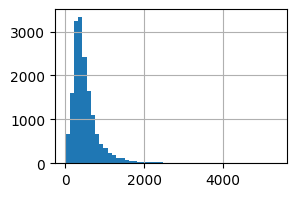

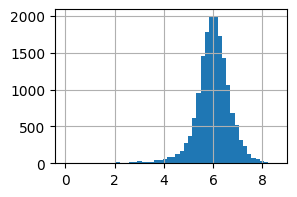

In [31]:
housing_num['households'].hist(bins=50, figsize=(3, 2))
plt.show()

np.log(housing_num['households']).hist(bins=50, figsize=(3, 2))
plt.show()

One strategy for multi-modal distributions is to compute a similarity rating feature for each of the modes in the data. In this example, we calculate such a feature for `housing_median_age` around 35.

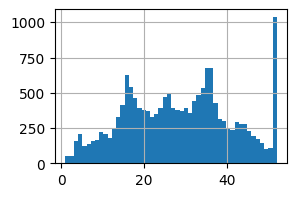

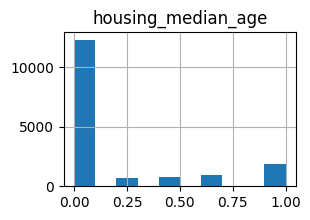

In [32]:
from sklearn.metrics.pairwise import rbf_kernel

housing["housing_median_age"].hist(bins=50, figsize=(3, 2))
plt.show()

# We will see a similiarity rating of each record's housing_median_age to the value 35.
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
age_simil_35 = pd.DataFrame(age_simil_35, columns=["housing_median_age"])
age_simil_35.hist(bins=10, figsize=(3, 2))
plt.show()

Sometimes we must also transform the target feature, but in order to make use of the predictions the model makes, we need an inverse transform to undo the operation (as we will predict target values in the transformed state).

In [33]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)

some_new_data = housing[["median_income"]].iloc[:5]  # Pretend this is new data.
scaled_predictions = model.predict(some_new_data)
print("scaled predictions:", scaled_predictions)
print()

predictions = target_scaler.inverse_transform(scaled_predictions)

print("predictions:", predictions)
print()

scaled predictions: [[-0.64466228]
 [ 0.80674175]
 [-0.52302364]
 [-0.5853166 ]
 [-0.12415952]]

predictions: [[131997.15275877]
 [299359.35844434]
 [146023.37185694]
 [138840.33653057]
 [192016.61557639]]



In [34]:
# This does not need to be done manually, tools exist to help.

from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)

print("predictions:", predictions)

predictions: [131997.15275877 299359.35844434 146023.37185694 138840.33653057
 192016.61557639]


array([[<Axes: title={'center': 'population'}>]], dtype=object)

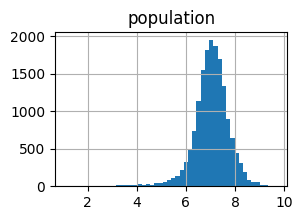

In [35]:
# We can write custom transformers as well. If a transformer doesn't need training, we can use a FunctionTransformer

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])

log_pop.hist(bins=50, figsize=(3,2))

In [36]:
# A transformer for determing similarity to 35.
rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.0]], gamma = 0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])

array([[<Axes: title={'center': 'sf_simil'}>]], dtype=object)

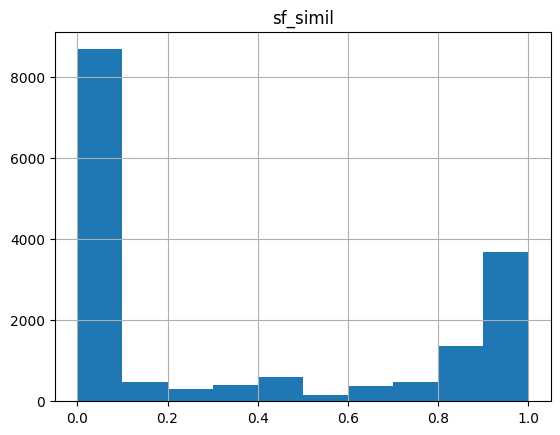

In [37]:
# A transformer measuring the similarity to "located in San Francisco". Location is another kind of multi-modal feature.
sf_coords = (37.7749, -122.41)
sf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

pd.DataFrame(sf_simil, columns=["sf_simil"]).hist(bins=10)

In [38]:
# A useful operation with transformers is to combine features.
ratio_transformer = FunctionTransformer(lambda X: X[:, [0]] / X[:, [1]])
ratio_transformer.transform(np.array([[1.0, 2.0], [3.0, 4.0]]))

array([[0.5 ],
       [0.75]])

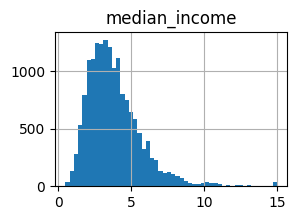

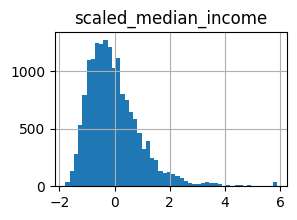

In [39]:
# Transformers can also be a kind of "trainable" thing, like a model or other scalers.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):
        X = check_array(X)
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        assert self.n_features_in_ == X.shape[1]
        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_

std_scaler_clone = StandardScalerClone()
scaled_median_income = std_scaler_clone.fit_transform(housing[["median_income"]])

housing[["median_income"]].hist(bins=50, figsize=(3, 2))
plt.show()

pd.DataFrame(scaled_median_income, columns=["scaled_median_income"]).hist(bins=50, figsize=(3, 2))
plt.show()

In [40]:
# Here's another trainable transformer that measure the similarity of a sample to its cluster's center.

from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} Similarity" for i in range(self.n_clusters)]

cluster_similarity = ClusterSimilarity(n_clusters=6, gamma=0.1)
cluster_similarity_values = cluster_similarity.fit_transform(housing[["housing_median_age"]])

In [41]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]], sample_weight=housing_labels)
print(cluster_simil.kmeans_.cluster_centers_)
similarities[:1]

[[  33.85060232 -117.78356573]
 [  37.78134861 -122.27837164]
 [  34.69948885 -119.75445997]
 [  32.94170114 -117.03285512]
 [  40.43172026 -122.55848854]
 [  36.70545668 -119.64670039]
 [  38.44920556 -121.13887954]
 [  38.51687956 -122.69442517]
 [  34.06008475 -118.33288417]
 [  37.22873003 -121.91686502]]


array([[7.76542973e-17, 9.79800335e-01, 5.48714294e-08, 1.39802338e-23,
        9.63314534e-04, 1.37867731e-04, 1.27105542e-01, 5.54756787e-01,
        4.68660945e-14, 5.60181642e-01]])

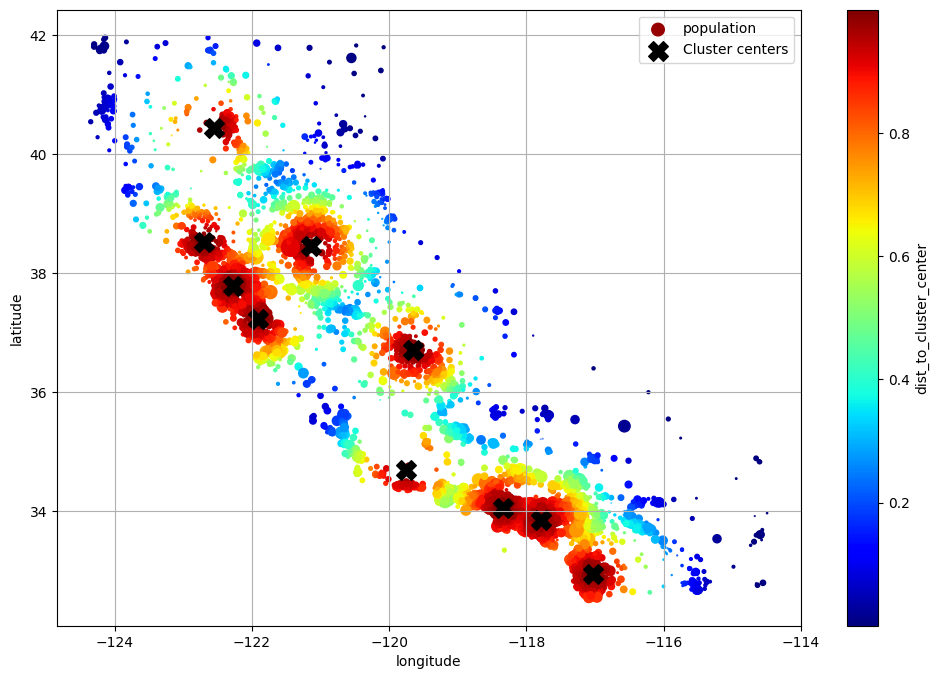

In [42]:
housing_for_map = housing.copy()
housing_for_map["dist_to_cluster_center"] = np.max(similarities, axis=1)
housing_for_map.plot(
    kind="scatter", x="longitude", y="latitude", grid=True,
    s=housing["population"] / 100, label="population",
    c="dist_to_cluster_center", cmap="jet", colorbar=True,
    sharex=False, figsize=(12, 8),
)
plt.scatter(
    x=cluster_simil.kmeans_.cluster_centers_[:, 1],
    y=cluster_simil.kmeans_.cluster_centers_[:, 0],
    c='black',
    s=200,
    marker='X',
    label='Cluster centers',
)
plt.legend()
plt.show()

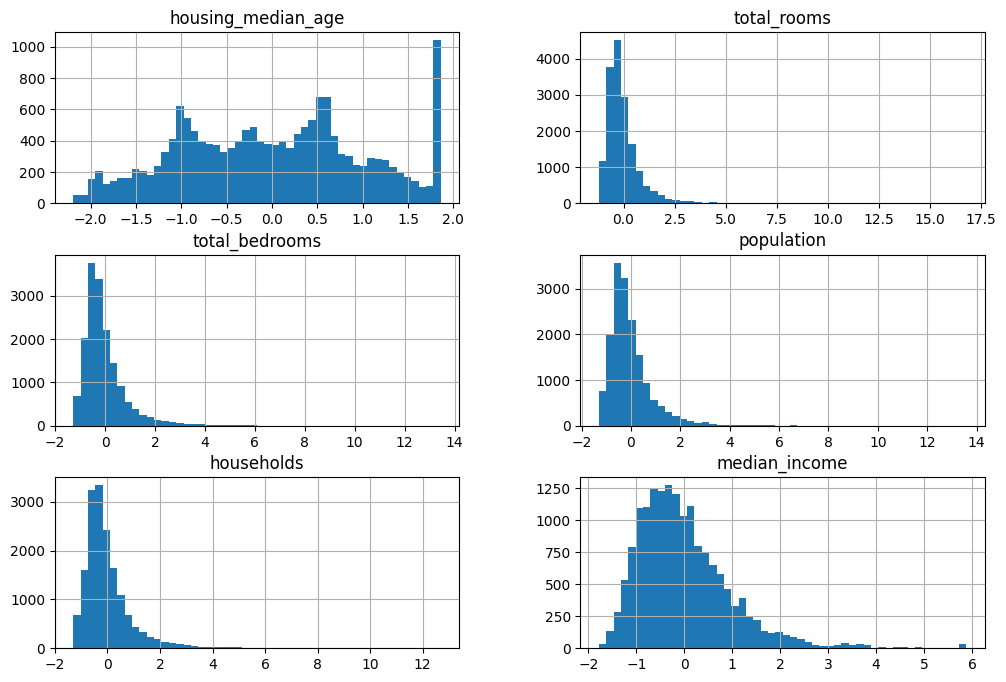

In [55]:
from sklearn.pipeline import Pipeline, make_pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

housing_num = housing.select_dtypes(include=[np.number])
housing_num = housing_num.drop(columns=["longitude", "latitude"])
out = pd.DataFrame(num_pipeline.fit_transform(housing_num), columns=num_pipeline.get_feature_names_out())
out.hist(bins=50, figsize=(12, 8))
plt.show()

In [65]:
from sklearn.compose import ColumnTransformer, make_column_selector

num_attribs = [
    'longitude', 'latitude',
    'housing_median_age', 'total_rooms',
    'total_bedrooms', 'population',
    'households', 'median_income',
]

cat_attribs = [
    'ocean_proximity',
]

cat_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore')),
])

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

out = preprocessing.fit_transform(housing)
out = pd.DataFrame(out, columns=preprocessing.get_feature_names_out())
out[:10]

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
0,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
1,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
2,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
3,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
4,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
5,-0.868193,1.088610,1.861119,-0.370856,-0.561571,-0.668194,-0.472739,-0.276883,0.0,1.0,0.0,0.0,0.0
6,0.606392,-0.838047,0.430885,-0.710868,-0.808122,-0.837181,-0.893265,1.185526,1.0,0.0,0.0,0.0,0.0
7,-1.278077,0.830784,0.589800,0.982782,0.858470,0.560383,1.018690,0.811824,0.0,0.0,0.0,1.0,0.0
8,0.566403,-0.622412,-0.522604,0.248303,0.673556,1.128543,0.642568,-0.593710,1.0,0.0,0.0,0.0,0.0
9,0.721359,-0.739605,-0.919891,-0.423482,0.080885,0.150248,0.177639,-1.418129,1.0,0.0,0.0,0.0,0.0


In [69]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ['ratio']

def make_ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler(),
    )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler(),
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1.0, random_state=42)

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
)

preprocessing = ColumnTransformer([
    ('bedrooms', make_ratio_pipeline(), ['total_bedrooms', 'total_rooms']),
    ('rooms_per_house', make_ratio_pipeline(), ['total_bedrooms', 'households']),
    ('people_per_house', make_ratio_pipeline(), ['population', 'households']),
    ('log', log_pipeline, ['total_bedrooms', 'total_rooms', 'population', 'households', 'median_income']),
    ('geo', cluster_simil, ['latitude', 'longitude']),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object)),
], remainder=default_num_pipeline)

housing_prepared = preprocessing.fit_transform(housing)
housing_prepared = pd.DataFrame(housing_prepared, columns=preprocessing.get_feature_names_out())
housing_prepared[:10]

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 Similarity,geo__Cluster 1 Similarity,...,geo__Cluster 6 Similarity,geo__Cluster 7 Similarity,geo__Cluster 8 Similarity,geo__Cluster 9 Similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
0,1.846624,-0.045837,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
1,-0.508121,-0.203599,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
2,-0.202155,-0.062881,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
3,-0.149006,-0.022758,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
4,0.963208,-0.127792,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800
5,-0.743942,-0.290943,-0.184066,-0.475568,-0.159448,-0.655784,-0.295737,-0.078518,6.423987e-01,1.159386e-11,...,1.543061e-04,3.632806e-01,8.154546e-06,2.324587e-14,0.0,1.0,0.0,0.0,0.0,1.861119
6,-0.489249,0.260628,0.050602,-1.058155,-0.856230,-1.076379,-1.255299,1.203677,8.006474e-11,9.595991e-01,...,1.139000e-28,1.111420e-14,4.431923e-02,3.744913e-01,1.0,0.0,0.0,0.0,0.0,0.430885
7,-0.389217,-0.167879,-0.158161,1.029712,1.126642,0.806339,1.105551,0.942136,7.868544e-01,2.160931e-12,...,6.336028e-05,7.521653e-01,8.513323e-07,1.114788e-15,0.0,0.0,0.0,1.0,0.0,0.589800
8,0.675013,-0.003022,0.128117,0.905123,0.580740,1.167537,0.864504,-0.498515,2.807941e-09,8.685613e-01,...,7.934107e-26,7.053833e-13,1.824289e-01,2.873697e-01,1.0,0.0,0.0,0.0,0.0,-0.522604
9,1.816054,-0.175507,-0.044126,0.406790,-0.246253,0.468905,0.492199,-2.283376,7.083722e-11,9.876226e-01,...,1.915751e-28,9.000955e-15,6.364003e-02,5.620424e-01,1.0,0.0,0.0,0.0,0.0,-0.919891
